# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [3]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=20000, max_test=2000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 2000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты, будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [4]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [5]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [6]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
linear_classifer.cross_entropy_loss(probs, 1)

5.006760443547122

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [7]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float))

Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [8]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
target_index = target_index.reshape(target_index.shape[1], -1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
target_index = target_index.reshape(target_index.shape[1], -1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Make sure maximum subtraction for numberic stability is done separately for every sample in the batch
probs = linear_classifer.softmax(np.array([[20,0,0], [1000, 0, 0]]))
assert np.all(np.isclose(probs[:, 0], 1.0))

Gradient check passed!
Gradient check passed!


### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [9]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [10]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [11]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

Epoch 0, loss: 2.420110
Epoch 1, loss: 2.312480
Epoch 2, loss: 2.302952
Epoch 3, loss: 2.302105
Epoch 4, loss: 2.302043
Epoch 5, loss: 2.302029
Epoch 6, loss: 2.302014
Epoch 7, loss: 2.302029
Epoch 8, loss: 2.302026
Epoch 9, loss: 2.302039


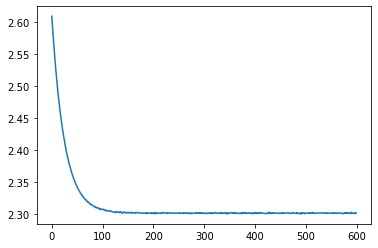

In [12]:
# let's look at the loss history!
plt.plot(loss_history)

In [13]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.1605
Epoch 0, loss: 2.302028
Epoch 1, loss: 2.302035
Epoch 2, loss: 2.302040
Epoch 3, loss: 2.302033
Epoch 4, loss: 2.302031
Epoch 5, loss: 2.302036
Epoch 6, loss: 2.302023
Epoch 7, loss: 2.302035
Epoch 8, loss: 2.302035
Epoch 9, loss: 2.302045
Epoch 10, loss: 2.302034
Epoch 11, loss: 2.302040
Epoch 12, loss: 2.302011
Epoch 13, loss: 2.302020
Epoch 14, loss: 2.302030
Epoch 15, loss: 2.302035
Epoch 16, loss: 2.302027
Epoch 17, loss: 2.302036
Epoch 18, loss: 2.302045
Epoch 19, loss: 2.302027
Epoch 20, loss: 2.302029
Epoch 21, loss: 2.302029
Epoch 22, loss: 2.302041
Epoch 23, loss: 2.302037
Epoch 24, loss: 2.302022
Epoch 25, loss: 2.302031
Epoch 26, loss: 2.302029
Epoch 27, loss: 2.302039
Epoch 28, loss: 2.302033
Epoch 29, loss: 2.302030
Epoch 30, loss: 2.302021
Epoch 31, loss: 2.302027
Epoch 32, loss: 2.302032
Epoch 33, loss: 2.302041
Epoch 34, loss: 2.302036
Epoch 35, loss: 2.302021
Epoch 36, loss: 2.302028
Epoch 37, loss: 2.302035
Epoch 38, loss: 2.302030
Epoch 39, loss: 2

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [14]:
num_epochs = 200
batch_size = 300

learning_rates = [1e-3, 1e-4, 1e-5]
reg_strengths = [1e-4, 1e-5, 1e-6]

best_classifier = None
best_val_accuracy = None

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially
for l_rate in learning_rates:
    for r_strength in reg_strengths:
        loss_history = classifier.fit(train_X, train_y, epochs=num_epochs, learning_rate=l_rate, batch_size=batch_size, reg=r_strength)
        pred = classifier.predict(val_X)
        accuracy = multiclass_accuracy(pred, val_y)
        if best_val_accuracy is None or best_val_accuracy < accuracy:
            best_classifier = classifier
            best_val_accuracy = accuracy

print('best validation accuracy achieved: %f' % best_val_accuracy)

Epoch 0, loss: 2.300545
Epoch 1, loss: 2.299004
Epoch 2, loss: 2.297517
Epoch 3, loss: 2.296075
Epoch 4, loss: 2.294650
Epoch 5, loss: 2.293242
Epoch 6, loss: 2.291866
Epoch 7, loss: 2.290507
Epoch 8, loss: 2.289170
Epoch 9, loss: 2.287850
Epoch 10, loss: 2.286547
Epoch 11, loss: 2.285268
Epoch 12, loss: 2.284003
Epoch 13, loss: 2.282748
Epoch 14, loss: 2.281523
Epoch 15, loss: 2.280300
Epoch 16, loss: 2.279111
Epoch 17, loss: 2.277928
Epoch 18, loss: 2.276745
Epoch 19, loss: 2.275621
Epoch 20, loss: 2.274480
Epoch 21, loss: 2.273353
Epoch 22, loss: 2.272243
Epoch 23, loss: 2.271152
Epoch 24, loss: 2.270074
Epoch 25, loss: 2.269010
Epoch 26, loss: 2.267948
Epoch 27, loss: 2.266897
Epoch 28, loss: 2.265883
Epoch 29, loss: 2.264858
Epoch 30, loss: 2.263865
Epoch 31, loss: 2.262858
Epoch 32, loss: 2.261889
Epoch 33, loss: 2.260913
Epoch 34, loss: 2.259952
Epoch 35, loss: 2.259001
Epoch 36, loss: 2.258086
Epoch 37, loss: 2.257151
Epoch 38, loss: 2.256236
Epoch 39, loss: 2.255327
Epoch 40, 

Epoch 124, loss: 2.166540
Epoch 125, loss: 2.166425
Epoch 126, loss: 2.166324
Epoch 127, loss: 2.166220
Epoch 128, loss: 2.166114
Epoch 129, loss: 2.166010
Epoch 130, loss: 2.165898
Epoch 131, loss: 2.165801
Epoch 132, loss: 2.165690
Epoch 133, loss: 2.165598
Epoch 134, loss: 2.165502
Epoch 135, loss: 2.165373
Epoch 136, loss: 2.165285
Epoch 137, loss: 2.165185
Epoch 138, loss: 2.165062
Epoch 139, loss: 2.164990
Epoch 140, loss: 2.164886
Epoch 141, loss: 2.164768
Epoch 142, loss: 2.164674
Epoch 143, loss: 2.164582
Epoch 144, loss: 2.164484
Epoch 145, loss: 2.164393
Epoch 146, loss: 2.164274
Epoch 147, loss: 2.164188
Epoch 148, loss: 2.164093
Epoch 149, loss: 2.163992
Epoch 150, loss: 2.163899
Epoch 151, loss: 2.163809
Epoch 152, loss: 2.163679
Epoch 153, loss: 2.163604
Epoch 154, loss: 2.163503
Epoch 155, loss: 2.163418
Epoch 156, loss: 2.163305
Epoch 157, loss: 2.163219
Epoch 158, loss: 2.163116
Epoch 159, loss: 2.163031
Epoch 160, loss: 2.162944
Epoch 161, loss: 2.162847
Epoch 162, l

Epoch 46, loss: 2.146642
Epoch 47, loss: 2.146638
Epoch 48, loss: 2.146633
Epoch 49, loss: 2.146627
Epoch 50, loss: 2.146623
Epoch 51, loss: 2.146617
Epoch 52, loss: 2.146613
Epoch 53, loss: 2.146608
Epoch 54, loss: 2.146604
Epoch 55, loss: 2.146598
Epoch 56, loss: 2.146593
Epoch 57, loss: 2.146588
Epoch 58, loss: 2.146584
Epoch 59, loss: 2.146579
Epoch 60, loss: 2.146574
Epoch 61, loss: 2.146568
Epoch 62, loss: 2.146564
Epoch 63, loss: 2.146558
Epoch 64, loss: 2.146553
Epoch 65, loss: 2.146549
Epoch 66, loss: 2.146543
Epoch 67, loss: 2.146539
Epoch 68, loss: 2.146534
Epoch 69, loss: 2.146530
Epoch 70, loss: 2.146524
Epoch 71, loss: 2.146520
Epoch 72, loss: 2.146514
Epoch 73, loss: 2.146509
Epoch 74, loss: 2.146505
Epoch 75, loss: 2.146500
Epoch 76, loss: 2.146495
Epoch 77, loss: 2.146491
Epoch 78, loss: 2.146483
Epoch 79, loss: 2.146480
Epoch 80, loss: 2.146475
Epoch 81, loss: 2.146469
Epoch 82, loss: 2.146465
Epoch 83, loss: 2.146460
Epoch 84, loss: 2.146454
Epoch 85, loss: 2.146450


Epoch 168, loss: 2.144737
Epoch 169, loss: 2.144732
Epoch 170, loss: 2.144727
Epoch 171, loss: 2.144723
Epoch 172, loss: 2.144719
Epoch 173, loss: 2.144715
Epoch 174, loss: 2.144709
Epoch 175, loss: 2.144703
Epoch 176, loss: 2.144699
Epoch 177, loss: 2.144693
Epoch 178, loss: 2.144689
Epoch 179, loss: 2.144684
Epoch 180, loss: 2.144680
Epoch 181, loss: 2.144676
Epoch 182, loss: 2.144670
Epoch 183, loss: 2.144666
Epoch 184, loss: 2.144661
Epoch 185, loss: 2.144655
Epoch 186, loss: 2.144651
Epoch 187, loss: 2.144647
Epoch 188, loss: 2.144643
Epoch 189, loss: 2.144636
Epoch 190, loss: 2.144633
Epoch 191, loss: 2.144628
Epoch 192, loss: 2.144623
Epoch 193, loss: 2.144617
Epoch 194, loss: 2.144614
Epoch 195, loss: 2.144607
Epoch 196, loss: 2.144604
Epoch 197, loss: 2.144598
Epoch 198, loss: 2.144595
Epoch 199, loss: 2.144590
Epoch 0, loss: 2.144548
Epoch 1, loss: 2.144545
Epoch 2, loss: 2.144540
Epoch 3, loss: 2.144535
Epoch 4, loss: 2.144530
Epoch 5, loss: 2.144526
Epoch 6, loss: 2.144521


Epoch 92, loss: 2.143969
Epoch 93, loss: 2.143968
Epoch 94, loss: 2.143968
Epoch 95, loss: 2.143967
Epoch 96, loss: 2.143967
Epoch 97, loss: 2.143967
Epoch 98, loss: 2.143966
Epoch 99, loss: 2.143966
Epoch 100, loss: 2.143965
Epoch 101, loss: 2.143965
Epoch 102, loss: 2.143964
Epoch 103, loss: 2.143964
Epoch 104, loss: 2.143964
Epoch 105, loss: 2.143963
Epoch 106, loss: 2.143963
Epoch 107, loss: 2.143962
Epoch 108, loss: 2.143962
Epoch 109, loss: 2.143961
Epoch 110, loss: 2.143961
Epoch 111, loss: 2.143960
Epoch 112, loss: 2.143960
Epoch 113, loss: 2.143959
Epoch 114, loss: 2.143959
Epoch 115, loss: 2.143959
Epoch 116, loss: 2.143958
Epoch 117, loss: 2.143958
Epoch 118, loss: 2.143957
Epoch 119, loss: 2.143957
Epoch 120, loss: 2.143956
Epoch 121, loss: 2.143956
Epoch 122, loss: 2.143955
Epoch 123, loss: 2.143955
Epoch 124, loss: 2.143955
Epoch 125, loss: 2.143954
Epoch 126, loss: 2.143954
Epoch 127, loss: 2.143953
Epoch 128, loss: 2.143953
Epoch 129, loss: 2.143952
Epoch 130, loss: 2.1

Epoch 13, loss: 2.143420
Epoch 14, loss: 2.143420
Epoch 15, loss: 2.143419
Epoch 16, loss: 2.143419
Epoch 17, loss: 2.143418
Epoch 18, loss: 2.143418
Epoch 19, loss: 2.143417
Epoch 20, loss: 2.143417
Epoch 21, loss: 2.143416
Epoch 22, loss: 2.143416
Epoch 23, loss: 2.143415
Epoch 24, loss: 2.143415
Epoch 25, loss: 2.143415
Epoch 26, loss: 2.143414
Epoch 27, loss: 2.143414
Epoch 28, loss: 2.143413
Epoch 29, loss: 2.143413
Epoch 30, loss: 2.143412
Epoch 31, loss: 2.143412
Epoch 32, loss: 2.143411
Epoch 33, loss: 2.143411
Epoch 34, loss: 2.143410
Epoch 35, loss: 2.143410
Epoch 36, loss: 2.143410
Epoch 37, loss: 2.143409
Epoch 38, loss: 2.143409
Epoch 39, loss: 2.143408
Epoch 40, loss: 2.143408
Epoch 41, loss: 2.143407
Epoch 42, loss: 2.143407
Epoch 43, loss: 2.143406
Epoch 44, loss: 2.143406
Epoch 45, loss: 2.143405
Epoch 46, loss: 2.143405
Epoch 47, loss: 2.143405
Epoch 48, loss: 2.143404
Epoch 49, loss: 2.143404
Epoch 50, loss: 2.143403
Epoch 51, loss: 2.143403
Epoch 52, loss: 2.143402


# Какой же точности мы добились на тестовых данных?

In [15]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.211500
